## 输出总结果

In [1]:
import argparse
import json
import sys, os
import pandas as pd
import numpy as np

# os.chdir('..')
print(os.getcwd())

/staff/fyyuan/repo/PPT-GPU


In [239]:
cmp_list = ['warp_inst_executed', 'achieved_occupancy', 'gpu_active_cycles', 'sm_active_cycles_sum', 'ipc',
            'l1_hit_rate', 'l2_hit_rate', 'gmem_tot_reqs', 'gmem_tot_sectors', 'l2_tot_trans', 'dram_tot_trans']
def get_summary(df, filter_error_hw=False):
    data = []
    for key in cmp_list:
        y1, y2 = df[f"{key}_hw"], df[f"{key}_sim"]

        if filter_error_hw:
            if "hit_rate" in key:
                valid_hw_res = y1 <= 1.01
                # print(y1.shape)
                shape1 = y1.shape
                y1 = y1[valid_hw_res]
                # print(y1.shape)
                shape2 = y1.shape
                if shape1 != shape2:
                    print(f"{key}: {shape1} -> {shape2}")
                y2 = y2[valid_hw_res]
        
        non_zero_idxs = y1 != 0
        MAPE = np.mean(np.abs(y1[non_zero_idxs] - y2[non_zero_idxs])/y1[non_zero_idxs])

        MAE = np.mean(np.abs(y1-y2))
        RMSE = np.sqrt(np.mean((y1 - y2)**2))
        NRMSE = np.sqrt(np.mean((y1 - y2)**2)) / np.mean(y1)
        # corr = np.corrcoef(y1, y2)[0, 1]
        corr = y1.corr(y2, method='pearson')
        kendall_tau = y1.corr(y2, method='kendall')

        data.append({"MAPE": MAPE, "NRMSE": NRMSE, "Correlation": corr, 'MAE': MAE, 'RMSE':RMSE, "kendall_tau": kendall_tau})
    df_summary = pd.DataFrame(data, index=cmp_list)
    return df_summary
def get_summary_by_bench(df, filter_error_hw=False):
    df_list = []
    keys = ["all"]
    df_list.append(get_summary(df, filter_error_hw=filter_error_hw))
    
    bench_groupby = df.groupby("bench", sort=False, as_index=False)
    for bench, group in bench_groupby:
        print(bench)
        df_list.append(get_summary(group, filter_error_hw=filter_error_hw))
        keys.append(bench)
    
    df_summary = pd.concat(df_list, keys=keys, axis=1)
    return df_summary

In [237]:
def print_compare_table(df_sim1, df_sim2, NRMSE=True, paper=False):
    cmp_list_dict = {k:k for k in cmp_list}
    if paper:
        # del cmp_list_dict['gmem_tot_reqs']
        # del cmp_list_dict['gmem_tot_sectors']
        # del cmp_list_dict['l1_hit_rate_stg']
        # del cmp_list_dict['l2_hit_rate_st']
        NRMSE =False
    
    def to_percentage(x):
        return "{:.2%}".format(x)
    def round_2digt(x):
        return "{:.2f}".format(x)
    L = []
    if NRMSE:
        eval_metrics = ['MAPE', 'Correlation', 'NRMSE', 'kendall_tau']
    else:
        eval_metrics = ['MAPE', 'Correlation']
    # eval_metrics = ['MAPE', 'Correlation', 'NRMSE', 'MAE', 'RMSE']
    for eval_metric in eval_metrics:
        if 'MAPE' == eval_metric:
            s1 = df_sim1[('all', eval_metric)].apply(to_percentage)
            s2 = df_sim2[('all', eval_metric)].apply(to_percentage)
        # elif 'Correlation'== eval_metric:
        elif True:
            s1 = df_sim1[('all', eval_metric)].apply(round_2digt)
            s2 = df_sim2[('all', eval_metric)].apply(round_2digt)
        else:
            s1 = df_sim1[('all', eval_metric)]
            s2 = df_sim2[('all', eval_metric)]
        L.append(s1)
        L.append(s2)
    merge_df = pd.concat(L, axis=1)
    merge_df.columns = pd.MultiIndex.from_product([eval_metrics, ['Old', 'New']])

    # rename metrics
    select_df = merge_df.loc[cmp_list_dict.keys()].rename(index=cmp_list_dict)
    return merge_df,select_df

### 读取 Excel

In [332]:
# sim_res = 'res_ppt-gpu_titanv_11.0_TITANV_cl32_old_param.xlsx'
# sim_res = 'res_ppt-gpu_titanv_11.0_TITANV_cl32-12-30.xlsx'
# sim_res = 'res_ppt-gpu_titanv_11.0_TITANV_fix_cycle.xlsx'
# sim_res2 = 'res_ppt2_titanv_11.0_TITANV_old_memory.xlsx'
# sim_res2 = 'res_ppt2_titanv_11.0_TITANV_paper_12-30.xlsx'
sim_res = 'res_ppt-gpu_titanv_11.0_TITANV_cl32.xlsx'
sim_res2 = 'res_ppt2_titanv_11.0_TITANV_paper.xlsx'

sim_res = 'res_ppt-gpu_titanv_11.0_A100-40G_cl32.xlsx'
sim_res2 = 'res_ppt2_titanv_11.0_A100-40G_paper.xlsx'

output_dir = 'paper_draw'

df_sim1 = pd.read_excel(sim_res, sheet_name="apps")
df_sim2 = pd.read_excel(sim_res2, sheet_name="apps")
# df_sim1 = pd.read_excel(sim_res, sheet_name="kernels")
# df_sim2 = pd.read_excel(sim_res2, sheet_name="kernels")

print(df_sim1.shape, df_sim2.shape)

(59, 25) (46, 25)


In [333]:
# 输出 df1 - df2
df_sim1[~df_sim1['app'].isin(df_sim2['app'])]['app']

44    gemm_bench-tensor/inference_half_35_1500_2560_0_0
45                                                 AN/1
48               pannotia-color/__data_ecology1_graph_1
49             pannotia-color/__data_G3_circuit_graph_1
50        pannotia-color_maxmin/__data_ecology1_graph_1
51      pannotia-color_maxmin/__data_G3_circuit_graph_1
52                      pannotia-fw/__data_256_16384_gr
53                pannotia-fw_block/__data_256_16384_gr
54                pannotia-fw_block/__data_512_65536_gr
55                 pannotia-mis/__data_ecology1_graph_1
56               pannotia-mis/__data_G3_circuit_graph_1
57       pannotia-pagerank/__data_coAuthorsDBLP_graph_1
58    pannotia-pagerank_spmv/__data_coAuthorsDBLP_gr...
Name: app, dtype: object

### 选择都存在的应用（必须）

In [67]:
def find_common(df1, df2):
    common_apps = df1[df1['app'].isin(df2['app'])]['app']
    df1_intersect = df1[df1['app'].isin(common_apps)]
    df2_intersect = df2[df2['app'].isin(common_apps)]
    df1_intersect.reset_index(drop=True, inplace=True)
    df2_intersect.reset_index(drop=True, inplace=True)
    return df1_intersect, df2_intersect

In [334]:
df_sim1, df_sim2 = find_common(df_sim1, df_sim2)
print(df_sim1.shape, df_sim2.shape)
# df_sim1['app']

(46, 25) (46, 25)


### 按照 yaml 重新选择应用

In [109]:
# %env app_yaml=/staff/fyyuan/repo/PPT-GPU-memory/memory_model/memory-apps.yml
# print(os.environ['app_yaml'])

sys.path.insert(0, "/staff/fyyuan/repo/PPT-GPU/")
from scripts.common import parse_app_definition_yaml, get_suite_info, get_app_arg_list

app_yaml = "/staff/fyyuan/repo/PPT-GPU/paper_scripts/apps.yml"

In [117]:
defined_apps = parse_app_definition_yaml(app_yaml)
suite_info = get_suite_info(app_yaml)

apps = []
for suite in suite_info['suites']:
    apps += defined_apps[suite]
    
app_and_arg_list = get_app_arg_list(apps)
# print(app_and_arg_list[:3])

def filter_app(df):
    df = df[df['app'].isin(app_and_arg_list)]
    # print(df.index)
    return df

In [118]:
df_sim1 = filter_app(df_sim1)
df_sim2 = filter_app(df_sim2)
print(df_sim1.shape, df_sim2.shape)

(33, 25) (33, 25)


### 过滤结果好的应用

In [ ]:
### 按照 cycle 过滤

In [326]:
def filter_apps(df, paper_apps):
    return df[df['app'].isin(paper_apps)]

In [335]:
# 使用之前过滤的应用
df_sim1, df_sim2 = filter_apps(df_sim1, paper_apps), filter_apps(df_sim2, paper_apps)
print(df_sim1.shape, df_sim2.shape)

(36, 25) (36, 25)


In [314]:
df_MAE1 = pd.read_excel(sim_res, sheet_name="apps_MAE")
df_MAE2 = pd.read_excel(sim_res2, sheet_name="apps_MAE")
# df_MAE1 = pd.read_excel(sim_res, sheet_name="kernels_MAE")
# df_MAE2 = pd.read_excel(sim_res2, sheet_name="kernels_MAE")
df_MAE1, df_MAE2 = find_common(df_MAE1, df_MAE2)

In [320]:
idx1 = abs(df_MAE1['gpu_active_cycles']) < 0.65
idx2 = abs(df_MAE2['gpu_active_cycles']) < 0.65

improv = idx2 & ~idx1
# pd.concat([idx1, idx2], axis=1)
print(idx1.sum(), idx2.sum(), improv.sum())

42 45 9


In [321]:
# 过滤结果好的应用
def filter(df1, df2, idx):
    return df1[idx], df2[idx]

# df_sim1, df_sim2 = filter(df_sim1, df_sim2, idx1)
df_sim1, df_sim2 = filter(df_sim1, df_sim2, idx2)
# df_sim1, df_sim2 = filter(df_sim1, df_sim2, improv)
print(df_sim1.shape, df_sim2.shape)

(45, 25) (45, 25)


In [293]:
### 按照 dram tot 过滤
idx1 = abs(df_MAE1['dram_tot_trans']) < 0.5
idx2 = abs(df_MAE2['dram_tot_trans']) < 0.5
improv = idx2 & ~idx1
print(idx1.sum(), idx2.sum(), improv.sum())

df_sim1, df_sim2 = filter(df_sim1, df_sim2, idx2)
print(df_sim1.shape, df_sim2.shape)

33 41 17
(27, 25) (27, 25)


/tmp/ipykernel_750839/1770481361.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return df1[idx], df2[idx]
/tmp/ipykernel_750839/1770481361.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return df1[idx], df2[idx]


In [217]:
def filter_file(file, apps, out=''):
    if not out:
        out = file.replace('.xlsx', '-filter.xlsx')
    excel_data = pd.ExcelFile(file)
    sheet_names = excel_data.sheet_names
    
    print(sheet_names)
    
    def filter_app(df, apps):
        return df[df['app'].isin(apps)]
    
    with pd.ExcelWriter(out, engine='xlsxwriter') as writer:
        for sheet_name in sheet_names:
            if 'summary' in sheet_name:
                df_summary = get_summary_by_bench(df_filter, filter_error_hw=True) # 上一个
                df_summary.to_excel(writer, sheet_name=sheet_name, index=True)
            else:
                df = excel_data.parse(sheet_name)
                df_filter = filter_app(df, apps)
                df_filter.to_excel(writer, sheet_name=sheet_name, index=False)
# def save(sim_res, sim_res2, idx, out='filter.xlsx'):
#     df_sim1 = pd.read_excel(sim_res, sheet_name="apps")
#     df_sim2 = pd.read_excel(sim_res2, sheet_name="apps")
#     df_MAE1 = pd.read_excel(sim_res, sheet_name="apps_MAE")
#     df_MAE2 = pd.read_excel(sim_res2, sheet_name="apps_MAE")
        
#     df_sim1, df_sim2 = filter(df_sim1, df_sim2, idx)
#     df_MAE1, df_MAE2 = filter(df_MAE1, df_MAE2, idx)
#     with pd.ExcelWriter(out, engine='xlsxwriter') as writer:
#         df_sim1.to_excel(writer, sheet_name='ppt-apps', index=False)
#         df_MAE1.to_excel(writer, sheet_name='ppt-apps_MAE', index=False)
#         df_sim2.to_excel(writer, sheet_name='our-apps', index=False)
#         df_MAE2.to_excel(writer, sheet_name='our-apps_MAE', index=False)

In [337]:
# apps = df_MAE1[improv]['app']
apps = paper_apps
filter_file(sim_res, apps)
filter_file(sim_res2, apps)
# save(sim_res, sim_res2, improv, out='improv.xlsx')

['apps', 'apps_summary', 'apps_MAE', 'kernels', 'kernels_summary', 'kernels_MAE', 'apps_extra', 'kernels_extra']
rodinia-3.1
polybench
GPU_Microbenchmark
Tango
pannotia
l2_hit_rate: (2241,) -> (2201,)
rodinia-3.1
l2_hit_rate: (1574,) -> (1535,)
polybench
GPU_Microbenchmark
Tango
pannotia
l2_hit_rate: (585,) -> (584,)
['apps', 'apps_summary', 'apps_MAE', 'kernels', 'kernels_summary', 'kernels_MAE', 'apps_extra', 'kernels_extra']
rodinia-3.1
polybench
GPU_Microbenchmark
Tango


/staff/fyyuan/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/staff/fyyuan/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)


l2_hit_rate: (1634,) -> (1595,)
rodinia-3.1
l2_hit_rate: (1574,) -> (1535,)
polybench
GPU_Microbenchmark
Tango


### 结果（过滤 hw 命中率大于 1)

过滤掉命中率大于 1 的应用

In [336]:
df_summary1 = get_summary_by_bench(df_sim1, filter_error_hw=True)
df_summary2 = get_summary_by_bench(df_sim2, filter_error_hw=True)
# print(df_summary2)
_, select_df = print_compare_table(df_summary1, df_summary2, NRMSE=True)
print(df_sim1.shape, df_sim2.shape)
select_df

rodinia-3.1
polybench
GPU_Microbenchmark
Tango
rodinia-3.1
polybench
GPU_Microbenchmark
Tango
(36, 25) (36, 25)


/staff/fyyuan/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/staff/fyyuan/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/staff/fyyuan/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/staff/fyyuan/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)


MAPE         Correlation       NRMSE        \
                         Old     New         Old   New   Old   New   
warp_inst_executed     5.30%   5.30%        1.00  1.00  0.05  0.05   
achieved_occupancy    21.66%  24.23%        0.93  0.92  0.35  0.47   
gpu_active_cycles     38.43%  62.67%        0.92  0.94  1.58  0.69   
sm_active_cycles_sum  67.82%  98.30%        0.97  0.98  0.81  0.74   
ipc                   31.18%  40.59%        0.94  0.64  0.63  0.98   
l1_hit_rate           15.91%  13.39%        0.99  0.99  0.13  0.09   
l2_hit_rate           43.20%  24.95%        0.04  0.57  0.52  0.34   
gmem_tot_reqs          8.85%   3.58%        1.00  1.00  0.55  0.01   
gmem_tot_sectors      14.10%   8.52%        1.00  1.00  0.39  0.01   
l2_tot_trans          45.25%  35.60%        0.99  0.99  1.00  0.67   
dram_tot_trans        58.41%  55.65%        0.90  0.99  1.61  0.26   

                     kendall_tau        
                             Old   New  
warp_inst_executed          0.98  0.98  
achieved_occupancy          0.83  0.83  
gpu_active_cycles           0.89  0.83  
sm_active_cycles_sum        0.95  0.90  
ipc                         0.86  0.77  
l1_hit_rate                 0.87  0.90  
l2_hit_rate                 0.01  0.36  
gmem_tot_reqs               0.98  0.99  
gmem_tot_sectors            0.98  0.99  
l2_tot_trans                0.95  0.96  
dram_tot_trans              0.89  0.95

In [325]:
paper_apps = df_sim1['app']

### 结果

In [126]:
df_summary1 = get_summary_by_bench(df_sim1, filter_error_hw=True)
df_summary2 = get_summary_by_bench(df_sim2, filter_error_hw=True)
# print(df_summary2)
_, select_df = print_compare_table(df_summary1, df_summary2, paper=True)
select_df

rodinia-3.1
polybench
Tango
pannotia
rodinia-3.1
polybench
Tango
pannotia


/staff/fyyuan/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/staff/fyyuan/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/staff/fyyuan/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/staff/fyyuan/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/staff/fyyuan/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/staff/fyyuan/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c

MAPE          Correlation      
                          Old      New         Old   New
warp_inst_executed      8.26%    8.26%        0.98  0.98
achieved_occupancy     22.83%   23.33%        0.91  0.90
gpu_active_cycles      62.66%   17.76%        0.98  1.00
sm_active_cycles_sum   73.52%   29.70%        0.92  0.99
ipc                   203.44%  243.40%        0.89  0.96
l1_hit_rate            16.85%   13.35%        0.97  0.98
l2_hit_rate            56.70%   21.64%        0.30  0.81
gmem_tot_reqs          10.19%    5.06%        1.00  1.00
gmem_tot_sectors       13.65%    7.97%        1.00  1.00
l2_tot_trans           27.11%   16.53%        0.97  0.99
dram_tot_trans         41.69%   20.93%        0.95  1.00

### 直接读取 summary 打印结果

In [ ]:
df_summary1 = pd.read_excel(sim_res, sheet_name="apps_summary", header=[0, 1], index_col=0)
df_summary2 = pd.read_excel(sim_res2, sheet_name="apps_summary", header=[0, 1], index_col=0)
# df_summary1 = pd.read_excel(sim_res, sheet_name="kernels_summary", header=[0, 1], index_col=0)
# df_summary2 = pd.read_excel(sim_res2, sheet_name="kernels_summary", header=[0, 1], index_col=0)
# print(df_summary2)
_, select_df = print_compare_table(df_summary1, df_summary2, NRMSE=True)

In [ ]:
select_df

### 获取 app 信息

In [ ]:
# sys.path.insert(0, "/staff/fyyuan/repo/PPT-GPU-memory/")
%load_ext autoreload
%autoreload 2
from scripts.common import parse_app_definition_yaml, get_suite_info, get_app_arg_list

import inspect
# print(inspect.getsource(get_suite_info))

app_yaml = "/staff/fyyuan/repo/PPT-GPU-memory/memory_model/memory-apps.yml"
# defined_apps = parse_app_definition_yaml(app_yaml)
suite_info = get_suite_info(app_yaml)

sim_res = 'memory_titanv_TITANV_ppt-gpu_base_CL32.xlsx'
df_kernels = pd.read_excel(sim_res, sheet_name="kernels")
df_kernels = filter_app(df_kernels)
df_apps = df_kernels.groupby('app', as_index=False, sort=False).size()
df_apps.rename(columns={'size': 'Kernels'}, inplace=True)
# df_apps

In [ ]:
import subprocess

def get_dir_size(path, get_logic=True):
    if get_logic:
        cmd = f'du --apparent-size {path}'
    else:
        cmd = f"du {path}"
    res = subprocess.run(cmd, shell=True, capture_output=True)
    size = res.stdout.decode().split('\t')[0]
    # print(cmd)
    # print(res.stdout.decode())
    # exit(1)
    return int(size)*1024
    
# print(df_sim1['app'])
# 统计应用 Trace 大小，运行实例数目
bench_info = {
    'abbr': [],
    'trace_size': [],
}
for app_arg in df_apps['app']:
    abbr = suite_info['map'][app_arg][-1]
    print(f"{abbr}: {app_arg}")
    bench_info['abbr'].append(abbr)

    trace_dir = '/staff/fyyuan/hw_trace01/ppt-gpu-titanv/11.0'
    app_memory_trace_dir = os.path.join(trace_dir, app_arg, 'memory_traces')
    # dir_size = 1
    dir_size = get_dir_size(app_memory_trace_dir)
    # print(dir_size)
    bench_info['trace_size'].append(dir_size)
df_bench_info = pd.concat([df_apps, pd.DataFrame(bench_info)], axis=1)
df_bench_info

In [ ]:
g = df_bench_info.groupby('abbr', as_index=False, sort=False)

df_bench_info2 = g.sum()
df_bench_info2

def bytes_to_human(x):
    G, M, K = 2**30, 2**20, 2**10
    if x >= G:
        return f'{x/G:.0f}GB'
    elif x >= M:
        return f'{x/M:.0f}MB'
    else:
        return f'{x/K:.0f}KB'
        
print(f'total: {df_bench_info2["trace_size"].sum()//2**30:.2f}GB')
print(f'total Kernels: {df_bench_info2["Kernels"].sum()}')
df_bench_info2['Trace size'] = df_bench_info2['trace_size'].apply(bytes_to_human)
df_bench_info2.drop(columns=['app'], inplace=True)
df_bench_info3 = df_bench_info2
df_bench_info3['Instance'] = g.size()['size']
df_bench_info3.reindex(columns=['abbr','Instance', 'Kernels', 'Trace size'])

## 画图

In [22]:
from scripts.common import get_suite_info

In [342]:
def get_metric_df(df_sim1, df_sim2, metric):
    '''df_sim1: PPT-GPU
    df_sim2: Ours
    '''
    df1 = df_sim1[['app', f"{metric}_sim"]]
    df2 = df_sim2[[f"{metric}_sim", f"{metric}_hw"]]
    df_new = pd.concat([df1, df2], axis=1)

    # rename columns
    df_new.columns = ['APP', 'PPT-GPU', 'Ours', 'HW']

    app_rename_map = {}
    for app in df_new['APP']:
        abbr = suite_info['map'][app][-1]
        app_rename_map[app] = abbr
    df_new['APP'] = df_new['APP'].map(app_rename_map)
    df_new = df_new.set_index('APP')
    return df_new

def draw_bar(df_sim1, df_sim2, draw_list):
    for metric in draw_list:
        print(f"Drawing {metric}...")
        df_metric = get_metric_df(df_sim1, df_sim2, metric)

        # df_metric.plot.bar()
        # save to excel
        with pd.ExcelWriter(os.path.join(output_dir, f"{metric}.xlsx"), engine='xlsxwriter') as writer:
            df_new.to_excel(writer, sheet_name=metric, index=False)

### MAPE 对比

In [144]:
def get_MAPE(df):
    MAPE = (df[f'{metric}_sim'] - df[f'{metric}_hw']) / df[f'{metric}_hw']
    MAPE.name = metric
    MAPE.index = df['app']
    
    app_rename_map = {}
    for app in df['app']:
        abbr = suite_info['map'][app][-1]
        app_rename_map[app] = abbr
    MAPE.rename(index=app_rename_map, inplace=True)
    return MAPE
def get_corr(df):
    y1, y2 = df[f'{metric}_sim'], df[f'{metric}_hw']
    corr = np.corrcoef(y1, y2)[0, 1]
    return corr

In [324]:
metric='gpu_active_cycles'
MAPE1=get_MAPE(df_sim1)
MAPE2=get_MAPE(df_sim2)
df = pd.concat([MAPE1, MAPE2], axis=1)
print(df.mean())
print(df.abs().mean())
df_abs = df
df_abs[metric]=abs(df[metric])
df_abs.plot.bar()

KeyError: 'l1_bw_32f/NO_ARGS'

### 条形图对比

<Axes: xlabel='APP'>

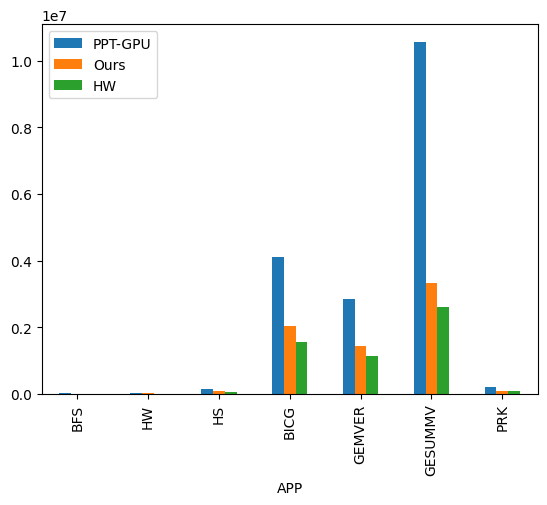

In [283]:
df1 = get_metric_df(df_sim1, df_sim2, 'gpu_active_cycles')
df1.plot.bar()

In [ ]:
# pd.DataFrame({'ld': df1, 'st': df2, 'tot': df3})

In [ ]:
def get_MAPE(df):
    df2 = (df['PPT-GPU'] - df['HW'])/df['HW']
    df3 = (df['Ours'] - df['HW'])/df['HW']
    df4 = pd.concat([df2, df3], axis=1)
    return df4
def get_big(df):
    df2 = (df['PPT-GPU'] > df['HW'])
    df3 = (df['Ours'] > df['HW'])
    df4 = pd.concat([df2, df3], axis=1)
    return df4

In [ ]:
BIG = get_big(df2).sum()
BIG

In [ ]:
MAPE = get_MAPE(df2)
print(MAPE.mean())
print(MAPE.abs().mean())
MAPE

In [ ]:
df4.plot.bar()

In [ ]:
df.plot.bar()

### Corrleation

In [250]:
import json

from matplotlib import pyplot as plt
import pandas as pd

dot_size = 50
is_black = False
def plot_sub(fig, ax, df, stat, log=False, log_x_min=-1, legend=True):
    y1, y2, y3 = df['PPT-GPU'], df['Ours'], df['HW']
    
    # 绘制散点图
    def get(y1, y2):
        non_zero_idxs = y1 != 0
        MAPE = np.mean(np.abs(y1[non_zero_idxs] - y2[non_zero_idxs])/y1[non_zero_idxs])
        # MAPE = ((y2 - y1)/y1).abs().mean()
        corr = np.corrcoef(y1, y2)[0, 1]
        kendall_tau = y1.corr(y2, method='kendall')
        if MAPE > 1:
            return f'Corr: {corr:.2} Err: {MAPE:.1f} {kendall_tau:.2f}'
        else:
            return f'Corr: {corr:.2} Err: {MAPE:.2f} {kendall_tau:.2f}'
    
    
    if is_black:
        # 使用不同的标记形状和填充
        ax.scatter(y3, y2, color='black', s=dot_size, marker='o', label=f'Our [{get(y3, y2)}]', edgecolors='0.3', linewidths=1, facecolors='0.8')  # 空心圆
        ax.scatter(y3, y1, color='black', s=dot_size, marker='^', label=f'PPT. [{get(y3, y1)}]', edgecolors='0.7', linewidths=1, facecolors='0.2')  # 斜线填充三角形
    else:
        ax.scatter(y3, y2, color=(1, 0.2, 0.2, 0.5), s=dot_size, marker='o', label=f'Our [{get(y3, y2)}]')  # 蓝色，透明
        ax.scatter(y3, y1, color=(0.2, 0.6, 1, 0.5), s=dot_size, marker='^', label=f'PPT. [{get(y3, y1)}]')  # 红色，透明
    
    if legend:
        if is_black:
            legend = ax.legend(frameon=True, edgecolor='black') #添加图例边框
            frame = legend.get_frame()
            frame.set_linewidth(1)
        else:
            ax.legend()

    # 计算范围
    min_val = min(min(y1.min(), y2.min()), y3.min())
    max_val = max(y1.max(), y2.max(), y3.max())
    # min_val -= 0.1 * (max_val - min_val)
    max_val *= 1.1

    # 绘制参考线
    ax.plot([min_val, max_val], [min_val, max_val],
            color='black', linestyle='--', linewidth=1, alpha=0.7)

    # 设置对数坐标轴
    if log:
        ax.set_xscale('log')
        ax.set_yscale('log')

        print(min_val, max_val)
        if log_x_min!=-1:
            ax.set_xlim(log_x_min, max_val)
            ax.set_ylim(log_x_min, max_val)
        else:
            ax.set_xlim(max(min_val, 1), max_val)
            ax.set_ylim(max(min_val, 1), max_val)
        
        # # 计算对数范围
        # log_min = np.log10(min_val)
        # log_max = np.log10(max_val)
        
        # # 设置一致的对数坐标范围
        # ax.set_xlim(10**log_min, 10**log_max)
        # ax.set_ylim(10**log_min, 10**log_max)
    else:
        ax.set_xlim(min_val, max_val)
        ax.set_ylim(min_val, max_val)

    # 美化边框
    # ax.spines['top'].set_visible(False)   # 隐藏顶部边框
    # ax.spines['right'].set_visible(False) # 隐藏右侧边框
    # ax.spines['left'].set_linewidth(1.5)  # 设置左侧边框线宽
    # ax.spines['bottom'].set_linewidth(1.5) # 设置底部边框线宽

    # 设置刻度样式
    # ax.tick_params(axis='both', which='major', direction='in', length=6, width=1.5, labelsize=12)
    # ax.tick_params(axis='both', which='minor', direction='in', length=3, width=1)

    # 设置坐标轴标签字体为 Times New Roman
    font = {
            # 'fontname': 'Times New Roman',
            # 'fontsize': 12
        }
    ax.set_xlabel(f"Hardware {stat}", **font)
    ax.set_ylabel(f"Simulate {stat}", **font)

    # 设置相等比例
    ax.set_aspect('equal', adjustable='box')

def draw_correl2(df1, df2, save_img, stat, log=False, log_x_min=-1, save_pdf='output.pdf', updown=False, figsize=(9, 4)):
    if updown:
        fig, axes = plt.subplots(2, 1, figsize=(8, 8))  # 设置画布大小
    else:
        fig, axes = plt.subplots(1, 2, figsize=figsize)  # 设置画布大小
    plot_sub(fig, axes[0], df1, stat[0])
    plot_sub(fig, axes[1], df2, stat[1])

    plt.tight_layout()
    # 保存图片
    fig.savefig(save_img, dpi=300, bbox_inches='tight')  # 高分辨率保存
    fig.savefig(save_pdf, format='pdf', bbox_inches='tight')
    plt.show()
    plt.close(fig)

def draw_correl3(df1, df2, df3, save_img, stat, log=False, log_x_min=-1, save_pdf='output.pdf', updown=False, figsize=(9, 4)):
    fig, axes = plt.subplots(1, 3, figsize=figsize)  # 设置画布大小
    plot_sub(fig, axes[0], df1, stat[0], log=log, log_x_min=-1)
    plot_sub(fig, axes[1], df2, stat[1], log=log, log_x_min=-1, legend=True)
    plot_sub(fig, axes[2], df3, stat[2], log=log, log_x_min=-1, legend=True)

    plt.tight_layout()
    # 保存图片
    fig.savefig(save_img, dpi=300, bbox_inches='tight')  # 高分辨率保存
    fig.savefig(save_pdf, format='pdf', bbox_inches='tight')
    plt.show()
    plt.close(fig)
    
def draw_correl(df, save_img, stat, log=False, log_x_min=-1, save_pdf='output.pdf'):
    fig, ax = plt.subplots(figsize=(4, 4))
    
    plot_sub(fig, ax, df, stat, log, log_x_min)
    # 保存图片
    fig.savefig(save_img, dpi=300, bbox_inches='tight')  # 高分辨率保存
    fig.savefig(save_pdf, format='pdf', bbox_inches='tight')
    plt.show()
    plt.close(fig)


#### plot

In [343]:
df1 = get_metric_df(df_sim1, df_sim2, 'gpu_active_cycles')
# draw_correl(df1, 'tmp_draw/corr_cycle.png', 'Cycle', log=True)

KeyError: 'l1_bw_32f/NO_ARGS'

In [268]:
dot_size = 20
df1 = get_metric_df(df_sim1, df_sim2, 'gpu_active_cycles')
df2 = get_metric_df(df_sim1, df_sim2, 'sm_active_cycles_sum')
df3 = get_metric_df(df_sim1, df_sim2, 'achieved_occupancy')

737 11622997.100000001
1235 279469696.0
0.0156 1.0855344809901537


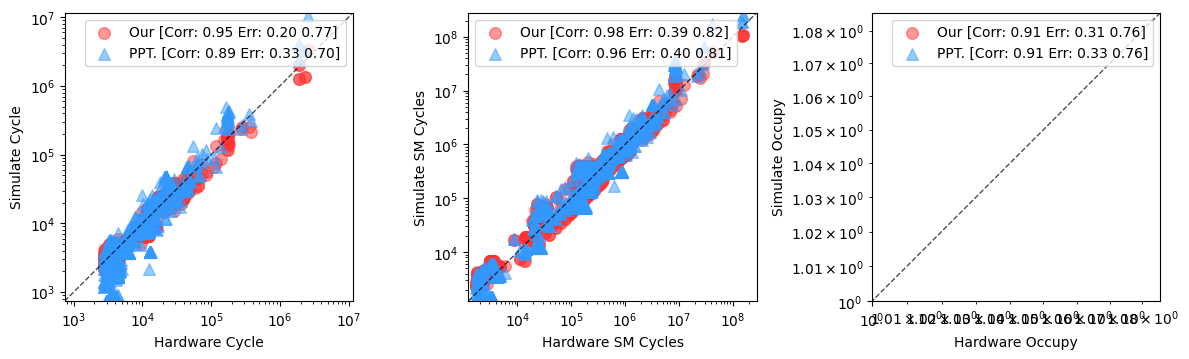

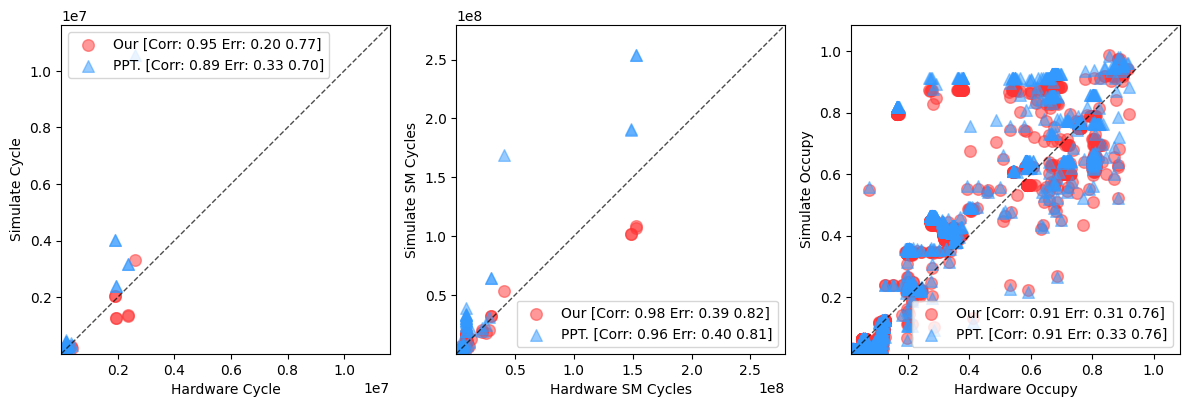

In [269]:
dot_size = 70
is_black = False
# draw_correl2(df1, df2, 'tmp_draw/corrl_dram.png', ['DRAM Writes', 'DRAM Total Req'], log=False, save_pdf='DRAM.pdf')
draw_correl3(df1, df2, df3, 'tmp_draw/corr.png', ['Cycle', 'SM Cycles', 'Occupy'], log=True, save_pdf='corr_3.pdf', figsize=(12, 8))
# draw_correl2(df3, df2, 'tmp_draw/corrl_dram_2.png', ['DRAM Reads', 'DRAM Total'], log=False, save_pdf='corrl_dram_2.pdf', figsize=(8, 8))

draw_correl3(df1, df2, df3, 'tmp_draw/corr.png', ['Cycle', 'SM Cycles', 'Occupy'], save_pdf='corr_3.pdf', figsize=(12, 8))
